# Numeric Integration for DAEs

The purpose of this notebook/class session is to provide the requisite background on numeric integration of DAEs. This helps appreciate the "direct transcription" approach for dynamic optimization used in `Pyomo.dae`.

In [1]:
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt

## Single-Step Runge-Kutta Methods
* ADD REFERENCE HERE
* Chapter 9 in [Biegler (2010)](https://epubs.siam.org/doi/book/10.1137/1.9780898719383)
* Chapter 17 in [McClarren (2018)](https://www.sciencedirect.com/book/9780128122532/computational-nuclear-engineering-and-radiological-science-using-python)

### General Form: Index 0 DAE

Consider the ODE system:
$$\begin{equation*}
\dot{z} = f(t,z), \quad z(t_0) = z_0
\end{equation*}$$

where $z(t)$ are the differentail variables and $f(t,z)$ is a (nonlinear) continous function.

The general Runge-Kutta formula is:
$$\begin{align*}
z_{i+1} &= z_{i} + h_i \sum_{k=1}^{n_s} b_k f(t_i + c_k h_i, \hat{z}_k) \\
    \hat{z}_k &= z_i + h_i \sum_{j=1}^{n_{rk}} a_{k,j} f(t_i + c_j h_i, \hat{z}_j), \quad k=1,...,n_s 
\end{align*}$$

where
* $z_i$ are the differential variables at the **start** of **step** $i$ (time $t_i$)
* $z_{i+1}$ are the differential variables at the **end** of **step** $i$ (time $t_{i+1}$)
* $\hat{z}_k$ are differential variables for **intermediate stage** $k$
* $h_i$ is the size for step $i$ such that $t_{i+1} = t_i + h_i$
* $n_s$ is the number of stages
* $n_{rk}$ is the number of $f(\cdot)$ evaluations to calculate intermediate $k$
* $a_{k,j}$ are coefficients, together known as the *Runge-Kutta matrix*
* $b_k$ are cofficients, known as the *weights*
* $c_k$ are coefficients, know as the *nodes*

$h_i$ is selected based on error tolerances

The choice for $A$, $b$ and $c$ selects the specific method in the *Runge-Kutta family*. These coefficients are often specific in a [Butcher block](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods#Explicit_Runge) (or Butcher tableau).

A Runge-Kutta method is called [**consistent**](https://en.wikiversity.org/wiki/Numerical_Analysis/stability_of_RK_methods) if:
$$\begin{equation*}
\sum_{k=1}^{n_s} b_k = 1 \quad \mathrm{and} \quad \sum_{j=1}^{n_s} a_{k,j} = c_k
\end{equation*}$$

### Explicit (Forward) Euler

Consider one of the simplest Runge-Kutta methods:

$$z_{i+1} = z_{i} + h_i~f(t_i, z_i)$$

What are $A$, $b$ and $c$ in the general formula?

$n_s = 1$. This is only a single stage. Thus we only need to determine $c_1$, $b_1$, and $n_{r1}$

Moreover, $\hat{z}_1 = z_i$ because $f(\cdot)$ is only evaluated at $t_i$ and $z_i$. This implies:
* $n_{r1} = 0$
* $c_1 = 0$
* $b_1 = 1$
* $A$ is empty because $n_{r1} = 0$

The implementation is very straightword (see below). We can calculate $z_{i+1}$ with a single line!

In [2]:
def create_steps(tstart,tend,dt):
    n = int(np.ceil((tend-tstart)/dt))
    return dt*np.ones(n)

def explicit_euler(f,h,z0):
    '''
    Arguments:
        f: function that returns rhs of ODE
        h: list of step sizes
        z0: initial conditions
        
    Returns:
        t: list of time steps. t[0] is 0.0 by default
        z: list of differential variable values
    '''
    
    # Number of timesteps
    nT = len(h) + 1
    
    t = np.zeros(nT)
    
    # Number of states
    nZ = len(z0)
    Z = np.zeros((nT,nZ))
    
    # Copy initial states
    Z[0,:] = z0
    
    for i in range(1,nT):
        
        i_ = i-1
        
        # Advance time
        t[i] = t[i_] + h[i_]
        
        # Implicit Euler formula
        Z[i,:] = Z[i_,:] + h[i_]*f(t[i_],Z[i_,:])
        
    return t, Z

### Implicit (Backward) Euler

Consider another simple Runge-Kutta method:

$$z_{i+1} = z_{i} + h_i~f(t_{i+1}, z_{i+1})$$

What are $A$, $b$ and $c$ to express using the general formula?

$n_s = 1$. Thus is only a single stage. Moreover, $\hat{z}_1 = z_{i+1}$ because $f(\cdot)$ is evaluated at $t_{i+1}$ and $z_{i+1}$. This implies:
* $b_1 = 1$
* $c_1 = 1$

Moreover, $z_{i+1} = z_{i} + h_i~f(t_{i+1}, z_{i+1})$ implies $\hat{z}_1 = z_i + h_i f(t_{i+1}, \hat{z}_1)$. Thus:
* $a_{1,1} = 1$

Notice that the formula for $z_{i+1}$ is implicit. We need to solve a (nonlinear) system of equations to calculate the step.

In [3]:
def implicit_euler(f,h,z0):
    '''
    Arguments:
        f: function that returns rhs of ODE
        h: list of step sizes
        z0: initial conditions
        
    Returns:
        t: list of time steps. t[0] is 0.0 by default
        z: list of differential variable values
    '''
    
    # Number of timesteps
    nT = len(h) + 1
    
    t = np.zeros(nT)
    
    # Number of states
    nZ = len(z0)
    Z = np.zeros((nT,nZ))
    
    # Copy initial states
    Z[0,:] = z0
    
    for i in range(1,nT):
        
        i_ = i-1
        
        # Advance time
        t[i] = t[i_] + h[i_]
        
        ## Implicit Runge-Kutta formula.
        ## Need to solve nonlinear system of equations.
        
        # Use Explicit Euler to calculate initial guess
        Z[i,:] = Z[i_,:] + h[i_]*f(t[i_],Z[i_,:])
        
        # Solve nonlinear equation
        implicit = lambda z : Z[i_,:] + h[i_]*f(t[i_],z) - z
        Z[i,:] = opt.fsolve(implicit, Z[i,:])
        
        
    return t, Z

### Comparison

Let's test this on a simple problem:
$$\dot{z}(t) = -\lambda z(t), \qquad z_0 = 1.$$ The solution to this problem is 
$$z(t) = e^{-\lambda t}.$$

For simplicity, let's numerically analyze $\lambda = 1$.

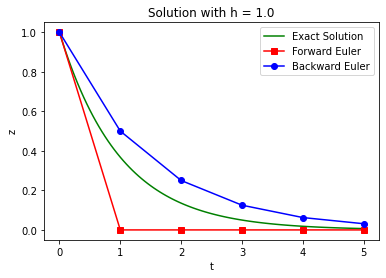

In [6]:
rhs = lambda t, z: -z
sln = lambda t: np.exp(-t)

dt = 1.0
h = create_steps(0.0,5.0,dt)

z0 = [1]

te, Ze = explicit_euler(rhs, h, z0)
ti, Zi = implicit_euler(rhs, h, z0)

plt.figure()

# Use 101 points for exact to make it smooth
texact = np.linspace(0.0,np.sum(h),101)

# Plot solutions
plt.plot(texact, sln(texact),color='green',label="Exact Solution")
plt.plot(te,Ze,color='red',marker='s',label='Forward Euler')
plt.plot(ti,Zi,color='blue',marker='o',label='Backward Euler')
plt.xlabel('t')
plt.ylabel('z')
plt.legend()
plt.title('Solution with h = '+ str(dt))
plt.show()

### Stability

Keeping $\lambda = 1$, are there any limits on step size?



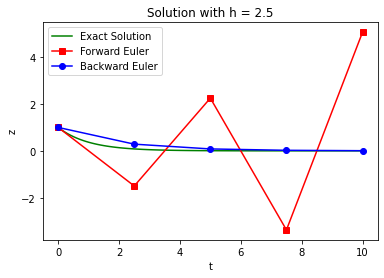

In [7]:
dt = 2.5
h = create_steps(0.0,10.0,dt)

z0 = [1]

te, Ze = explicit_euler(rhs, h, z0)
ti, Zi = implicit_euler(rhs, h, z0)

plt.figure()

# Use 101 points for exact to make it smooth
texact = np.linspace(0.0,np.sum(h),101)

# Plot solutions
plt.plot(texact, sln(texact),color='green',label="Exact Solution")
plt.plot(te,Ze,color='red',marker='s',label='Forward Euler')
plt.plot(ti,Zi,color='blue',marker='o',label='Backward Euler')
plt.xlabel('t')
plt.ylabel('z')
plt.legend()
plt.title('Solution with h = '+ str(dt))
plt.show()

**Key observation:** forward (explicit) Euler becomes unstable with large steps whereas backward (implicit) Euler is stable.

There is a good mathematical reason for this! See http://www.it.uu.se/edu/course/homepage/bridging/ht13/Stability_Analysis.pdf for details.

**Key results** (for this specific test problem):
* Explicit Euler requires step sizes with $h < 2/\lambda$.
* Implicit Euler is *unconditionally stable* provided $\lambda > 0$.
* Similar analysis and concepts extend to Runge-Kutta methods.

### Error Analysis

How does our choice in step size $h$ impact the error of these numerical techniques?

Excellent tutorial: http://www.math.unl.edu/~gledder1/Math447/EulerError

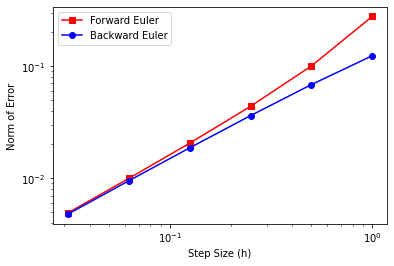

Slope for Forward Euler: 1.0220608473216777
Slope for Backward Euler: 0.9874086317220228


In [10]:
Delta_t = np.array([1.0,.5,.25,.125,.0625,.0625/2])
t_final = 2
error_forward = np.zeros(Delta_t.size)
error_backward = np.zeros(Delta_t.size)

for i in range(0,len(Delta_t)):
    
    # create steps
    h = create_steps(0.0,t_final,Delta_t[i])
    
    # solve
    t,ze = explicit_euler(rhs, h, z0)
    t,zi = implicit_euler(rhs, h, z0)
    zsln = np.exp(-t)
    
    n = len(t) - 1
    
    # Calculate error
    error_forward[i] = np.linalg.norm(ze[:,0] - zsln)/np.sqrt(n)
    error_backward[i] = np.linalg.norm(zi[:,0] - zsln)/np.sqrt(n)
    

plt.loglog(Delta_t,error_forward,'s-',color="red",label="Forward Euler")
plt.loglog(Delta_t,error_backward,'o-',color="blue",label="Backward Euler")

#slope = (np.log(error[-1]) - np.log(error[-2]))/(np.log(Delta_t[-1])- np.log(Delta_t[-2]))
#plt.title("Slope of Error is " + str(slope))
plt.xlabel("Step Size (h)")
plt.ylabel("Norm of Error")
plt.legend()
plt.show()

# Calculate slope
calc_slope = lambda error: (np.log(error[-1]) - np.log(error[-2]))/(np.log(Delta_t[-1])- np.log(Delta_t[-2]))

print("Slope for Forward Euler: " + str(calc_slope(error_forward)))
print("Slope for Backward Euler: " + str(calc_slope(error_backward)))

Notice that the error indicates that this is a first-order method in $\Delta t$: when I decrease $\Delta t$ by a factor of 2, the error decreases by a factor of 2.  In this case we measured the error with a slightly different error norm:
$$\mathrm{Error} = \frac{1}{\sqrt{N}}\sqrt{\sum_{n=1}^{N} \left(y^n_\mathrm{approx} - y^n_\mathrm{exact}\right)^2},$$
where $N$ is the number of steps the ODE is solved over.

**Key Results**:
* Implicit and Explicit Euler have $O(h^2)$ local error and $O(h)$ global error.

### Extensions to DAEs

Consider semi-explicit DAEs:
$$\begin{equation*}
\dot{z} = f(t,z,y), \quad g(z,y) = 0, \quad z(t_0) = z_0
\end{equation*}$$

Runge-Kutta methods are easy to extend.

$$\begin{align*}
z_{i+1} &= z_{i} + h_i \sum_{k=1}^{n_s} b_k f(t_i + c_k h_i, \hat{z}_k, \hat{y}_k) \\
    \hat{z}_k &= z_i + h_i \sum_{j=1}^{n_{rk}} a_{k,j} f(t_i + c_j h_i, \hat{z}_j, \hat{y}_j), \quad k=1,...,n_s \\
    0 &= g(\hat{z}_k, \hat{y}_k), \quad k=1,...,n_s
\end{align*}$$

**Key Results**. If DAE is index 1, then similar stability and order properties as for ODE problems.

**Discussion:** Why are *implicit* RK methods always used for DAE systems?

## Quadrature Rules

* Chapter 16 in [McClarren (2018)](https://www.sciencedirect.com/book/9780128122532/computational-nuclear-engineering-and-radiological-science-using-python).
* Chapter 10 in [Biegler (2010)](https://epubs.siam.org/doi/book/10.1137/1.9780898719383)

### Main Idea

Approximate integral $I$ with weighted sum of function evaluations:

$$\begin{equation*}
I := \int_{-1}^{1} f(x) dx \approx \underbrace{\sum_{l=1}^{L} w_l f(x_l)}_{\text{quadrature rule}}
\end{equation*}$$

where:
* $x_l$ are nodes (abscissas)
* $w_l$ are weights
* $n$ number of nodes and weights

Central questions:
* How to choose *nodes* and *weights*?
* How does this choice impact approximation error?
* How does $n$ impact approximation error?

### Degree and order of a polynomial

Consider the polynomial:

$$p(t) = a_0 + a_1 t + ... + a_K t^K.$$

$p(t)$ is said to be of **order K+1** as it has K+1 coefficients $a_0, ... a_K$.

The **degree** of the polynomial is the highest power with a non-zero coefficient. Thus if $a_K \neq 0$, then $p(t)$ is degree K.

Example: What is the degree of $2 x^3 - x^2 + 1$? What can you say about its order?

### Gauss-Legrenge Quadrature

For a *specific choice of nodes and weights*, the quadrature rule $\sum_{l=1}^{L} w_l f(x_l)$ is exact for integral $I$ is $f(x)$ is a polynomial of degree $2L-1$ or less. This specific case is the **optimal** (most accurate) rule known as the Gauss-Legrenge quadrature.

The weights and abscissas are given for $L$ up to 8:

<table>
<tbody><tr><td>$L$</td><td>$x_l$</td><td>$w_l$</td></tr></tbody>
<tbody><tr><td>1</td><td>0</td><td>2.0000000000000000000000000</td></tr></tbody>
<tbody><tr><td>2</td><td>±0.5773502691896257645091488</td><td>1.0000000000000000000000000</td></tr></tbody><p></p><tbody><tr><td rowspan="2">3</td><td>0</td><td>0.8888888888888888888888889</td></tr><tr><td>±0.7745966692414833770358531</td><td>0.5555555555555555555555556</td></tr></tbody><p></p><tbody><tr><td rowspan="2">4</td><td>±0.3399810435848562648026658</td><td>0.6521451548625461426269361</td></tr><tr><td>±0.8611363115940525752239465</td><td>0.3478548451374538573730639</td></tr></tbody><p></p><tbody><tr><td rowspan="3">5</td><td>0</td><td>0.5688888888888888888888889</td></tr><tr><td>±0.5384693101056830910363144</td><td>0.4786286704993664680412915</td></tr><tr><td>±0.9061798459386639927976269</td><td>0.2369268850561890875142640</td></tr></tbody><p></p><tbody><tr><td rowspan="3">6</td><td>±0.2386191860831969086305017</td><td>0.4679139345726910473898703</td></tr><tr><td>±0.6612093864662645136613996</td><td>0.3607615730481386075698335</td></tr><tr><td>±0.9324695142031520278123016</td><td>0.1713244923791703450402961</td></tr></tbody><p></p><tbody><tr><td rowspan="4">7</td><td>0</td><td>0.4179591836734693877551020</td></tr><tr><td>±0.4058451513773971669066064</td><td>0.3818300505051189449503698</td></tr><tr><td>±0.7415311855993944398638648</td><td>0.2797053914892766679014678</td></tr><tr><td>±0.9491079123427585245261897</td><td>0.1294849661688696932706114</td></tr></tbody><p></p><tbody><tr><td rowspan="4">8</td><td>±0.1834346424956498049394761</td><td>0.3626837833783619829651504</td></tr><tr><td>±0.5255324099163289858177390</td><td>0.3137066458778872873379622</td></tr><tr><td>±0.7966664774136267395915539</td><td>0.2223810344533744705443560</td></tr><tr><td>±0.9602898564975362316835609</td><td>0.1012285362903762591525314</td></tr></tbody>
</table>

### Code

In [11]:
import numpy as np
import matplotlib.pyplot as plt
def GLQuad(f, L=8,dataReturn = False):
    """Compute the Gauss-Legendre Quadrature estimate 
    of the integral of f(x) from -1 to 1
    Inputs:
    f:   name of function to integrate
    L:   Order of integration rule (8 or less)
    
    Returns:
    G-L Quadrature estimate"""
    assert(L>=1)
    if (L==1):
        weights = np.ones(1)*2
        xs = np.array([0])
    elif (L==2):
        weights = np.ones(2)
        xs = np.array([-np.sqrt(1.0/3.0),np.sqrt(1.0/3.0)])
    elif (L==3):
        weights = np.array([0.8888888888888888888888889,
                            0.5555555555555555555555556,
                            0.5555555555555555555555556])
        xs = np.array([0.0,-0.7745966692414833770358531,
                       0.7745966692414833770358531])
    elif (L==4):
        weights = np.array([0.6521451548625461426269361,0.6521451548625461426269361,
                            0.3478548451374538573730639,0.3478548451374538573730639])
        xs = np.array([-0.3399810435848562648026658, 0.3399810435848562648026658,
                       -0.8611363115940525752239465, 0.8611363115940525752239465])
    elif (L==5):
        weights = np.array([0.5688888888888888888888889,
                            0.4786286704993664680412915,0.4786286704993664680412915,
                            0.2369268850561890875142640,0.2369268850561890875142640])
        xs = np.array([0.0,-0.5384693101056830910363144,0.5384693101056830910363144,
                       -0.9061798459386639927976269,0.9061798459386639927976269])
    elif (L==6):
        weights = np.array([0.4679139345726910473898703,0.4679139345726910473898703,
                            0.3607615730481386075698335,0.3607615730481386075698335,
                            0.1713244923791703450402961,0.1713244923791703450402961])
        xs = np.array([-0.2386191860831969086305017, 0.2386191860831969086305017,
                       -0.6612093864662645136613996, 0.6612093864662645136613996,
                       -0.9324695142031520278123016, 0.9324695142031520278123016])
    elif (L==7):
        weights = np.array([0.4179591836734693877551020,
                            0.3818300505051189449503698,0.3818300505051189449503698,
                            0.2797053914892766679014678,0.2797053914892766679014678,
                            0.1294849661688696932706114,0.1294849661688696932706114])
        xs = np.array([0.0,-0.4058451513773971669066064,0.4058451513773971669066064,
                       -0.7415311855993944398638648,0.7415311855993944398638648,
                       -0.9491079123427585245261897,0.9491079123427585245261897])
    elif (L==8):
        weights = np.array([0.3626837833783619829651504,0.3626837833783619829651504,
                            0.3137066458778872873379622,0.3137066458778872873379622,
                            0.2223810344533744705443560,0.2223810344533744705443560,
                            0.1012285362903762591525314,0.1012285362903762591525314])
        xs = np.array([-0.1834346424956498049394761, 0.1834346424956498049394761,
                       -0.5255324099163289858177390, 0.5255324099163289858177390,
                       -0.7966664774136267395915539, 0.7966664774136267395915539,
                       -0.9602898564975362316835609, 0.9602898564975362316835609])
    else: #use numpy's function
        xs, weights = np.polynomial.legendre.leggauss(L)
    
    quad_estimate = np.sum(weights*f(xs))
    if (dataReturn):
        return quad_estimate, weights, xs
    else:
        return quad_estimate

### Visualize Weights

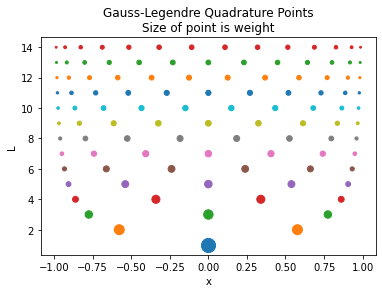

In [12]:
L = np.arange(1,15)
f = lambda x: x
for l in L:
    quad_est, weights, xs = GLQuad(f,l,dataReturn=True)
    levels = weights*0 + l
    plt.scatter(xs, levels, s=weights*100)
plt.xlabel("x")
plt.ylabel("L")
plt.title("Gauss-Legendre Quadrature Points\nSize of point is weight")
plt.show()

### Why $2L-1$?

Let $f(x) = a_{2L-1} x^{2L-1} + a_{2L-2} x^{2L-2} + ... + a_{1} x^1 + a_{0}$

This polynomial has $2L$ coefficients. Likewise, $\int f(x)dx$ has $2L$ coefficients plus the constant of integration. This is the same number of degrees of freedom we have in choosing the *weights* and *nodes*.

### How to determine the nodes and weights? 

One way to derive the Gauss-Legendre quadrature rules is by looking at the integral generic monomials of degree 0 up to $2L-1$ and setting each equal to the $L$ point Gauss-Legendre quadrature rule:
$$ \int\limits_{-1}^{1} dx\, a_0 x^0 =  a_0\sum_{l=1}^L w_l x_l^0,$$
$$ \int\limits_{-1}^{1} dx\, a_1 x^1 = a_1\sum_{l=1}^L w_l x_l^1,$$
and continuing until
$$ \int\limits_{-1}^{1} dx\, a_{2L-1} x^{2L-1} = a_{2L-1}\sum_{l=1}^L w_l x_l^{2L-1}.$$
Notice that the $a_i$ **constants cancel out** of each equation so they do not matter. This system is $2L$ equations with $L$ weights, $w_l$, and $L$ abscissas (nodes), $x_l$. We could solve these equations to get the weights and abscissas, though this is not how it is done in practice generally---this is accomplished by using the theory of orthogonal polynomials.

### Polynomial Example

As a simple demonstration of the Gauss-Legendre quadrature, let's show that it integrates polynomials of degree $2L-1$ exactly.  Consider the integral
$$\int\limits_{-1}^1 (x+1)^{2L-1}\,dx = \frac{2^{2 L-1}}{L}.$$

In [4]:
L = np.arange(1,12)
for l in L:
    
    # Create f
    f = lambda x: (x+1)**(2*l-1)
    
    # Evaluate exact (analytic) solution
    integral = 2**(2*l - 1)/l
    
    # Evaluate quadrature rule
    GLintegral = GLQuad(f,l)
    
    # Print results
    print("L =", l,"\t Estimate is",GLintegral,
          "Exact value is",integral, 
          "\nAbs. Relative Error is", np.abs(GLintegral-integral)/integral)

L = 1 	 Estimate is 2.0 Exact value is 2.0 
Abs. Relative Error is 0.0
L = 2 	 Estimate is 3.9999999999999996 Exact value is 4.0 
Abs. Relative Error is 1.1102230246251565e-16
L = 3 	 Estimate is 10.666666666666668 Exact value is 10.666666666666666 
Abs. Relative Error is 1.6653345369377348e-16
L = 4 	 Estimate is 31.99999999999999 Exact value is 32.0 
Abs. Relative Error is 3.3306690738754696e-16
L = 5 	 Estimate is 102.39999999999995 Exact value is 102.4 
Abs. Relative Error is 5.551115123125783e-16
L = 6 	 Estimate is 341.33333333333337 Exact value is 341.3333333333333 
Abs. Relative Error is 1.6653345369377348e-16
L = 7 	 Estimate is 1170.2857142857135 Exact value is 1170.2857142857142 
Abs. Relative Error is 5.828670879282072e-16
L = 8 	 Estimate is 4096.000000000003 Exact value is 4096.0 
Abs. Relative Error is 6.661338147750939e-16
L = 9 	 Estimate is 14563.555555555577 Exact value is 14563.555555555555 
Abs. Relative Error is 1.4988010832439613e-15
L = 10 	 Estimate is 52428.79

### Generalization

We are generally interested in integrals not just over the domain $x\in [-1,1]$.  We'll now make a function that does Gauss-Legendre quadrature over a general range using the formula
$$\int_a^b f(x)\,dx = \frac{b-a}{2} \int_{-1}^1 f\left(\frac{b-a}{2}z + \frac{a+b}{2}\right)\,dz.$$

In [13]:
def generalGL(f,a,b,L):
    """Compute the Gauss-Legendre Quadrature estimate 
    of the integral of f(x) from a to b
    Inputs:
    f:   name of function to integrate
    a:   lower bound of integral
    b:   upper bound of integral
    L:   Order of integration rule (8 or less)
    Returns:
    G-L Quadrature estimate"""
    assert(L>=1)
    #define a re-scaled f
    f_rescaled = lambda  z: f(0.5*(b-a)*z + 0.5*(a+b))
    integral = GLQuad(f_rescaled,L)
    return integral*(b-a)*0.5

Let's show that this version integrates polynomials of degree $2L-1$ exactly.  Consider the integral
$$\int\limits_{-3}^2 (x+1)^{2L-1}\,dx = \frac{9^L-4^L}{2 L}.$$

In [14]:
L = np.arange(1,12)
for l in L:
    f = lambda x: (x+1)**(2*l-1)
    integral = (9**l-4**l)/(2*l)
    GLintegral = generalGL(f,-3,2,l)
    print("L =", l,"\t Estimate is",GLintegral,
          "Exact value is",integral, 
          "\nAbs. Relative Error is", np.abs(GLintegral-integral)/integral)

L = 1 	 Estimate is 2.5 Exact value is 2.5 
Abs. Relative Error is 0.0
L = 2 	 Estimate is 16.249999999999996 Exact value is 16.25 
Abs. Relative Error is 2.1862853408003084e-16
L = 3 	 Estimate is 110.83333333333336 Exact value is 110.83333333333333 
Abs. Relative Error is 2.5643647606379557e-16
L = 4 	 Estimate is 788.1249999999999 Exact value is 788.125 
Abs. Relative Error is 1.4424975444455643e-16
L = 5 	 Estimate is 5802.500000000002 Exact value is 5802.5 
Abs. Relative Error is 3.1348374037843283e-16
L = 6 	 Estimate is 43945.4166666667 Exact value is 43945.416666666664 
Abs. Relative Error is 8.278403262589113e-16
L = 7 	 Estimate is 340470.35714285733 Exact value is 340470.35714285716 
Abs. Relative Error is 5.128874777992276e-16
L = 8 	 Estimate is 2686324.0625 Exact value is 2686324.0625 
Abs. Relative Error is 0.0
L = 9 	 Estimate is 21508796.944444507 Exact value is 21508796.944444444 
Abs. Relative Error is 2.9443736549946913e-15
L = 10 	 Estimate is 174286791.24999988 Ex

### Another Example

Let's see how Gauss-Quadrature performs on a function that is not polynomial:
$$\int_{0}^\pi \sin(x)\,dx = 2,$$

L = 1 Estimate is 3.141592653589793 Exact value is 2
L = 2 Estimate is 1.9358195746511373 Exact value is 2
L = 3 Estimate is 2.0013889136077436 Exact value is 2
L = 4 Estimate is 1.999984228457722 Exact value is 2
L = 5 Estimate is 2.000000110284472 Exact value is 2
L = 6 Estimate is 1.9999999994772704 Exact value is 2
L = 7 Estimate is 2.0000000000017906 Exact value is 2
L = 8 Estimate is 1.9999999999999951 Exact value is 2
L = 9 Estimate is 1.9999999999999998 Exact value is 2
L = 10 Estimate is 2.0000000000000004 Exact value is 2
L = 11 Estimate is 2.0000000000000013 Exact value is 2
L = 12 Estimate is 1.9999999999999987 Exact value is 2
L = 13 Estimate is 1.9999999999999998 Exact value is 2
L = 14 Estimate is 1.999999999999999 Exact value is 2


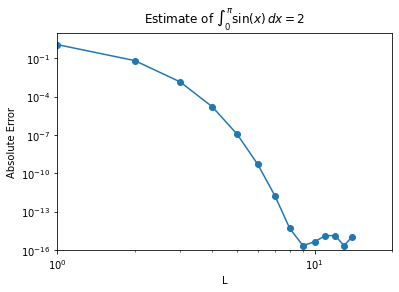

In [15]:
L = np.arange(1,15)
errors = np.zeros(L.size)
f = lambda x: np.sin(x)
integral = 2
for l in L:
    GLintegral = generalGL(f,0,np.pi,l)
    errors[l-1] = np.fabs(GLintegral-integral)
    print("L =",l,"Estimate is",GLintegral,"Exact value is",integral)
plt.loglog(L,errors,'o-')
plt.xlabel("L")
plt.ylabel("Absolute Error")
plt.title("Estimate of $\int_{0}^\pi \sin(x)\,dx = 2$")
plt.axis([1,20,10**-16,10**1])
plt.show()

Notice that we get to machine-precision by evaluating the integral at only 8 points!

This exponential convergence will only be obtained on smooth solutions without singularities in the function or its derivatives.

### A More Complicated Example

Consider:
$$ \int\limits_0^1 4 \sqrt{1-x^2}\,dx = \pi.$$
This integral has a singularity in its derivative at $x=1$. Gauss-Legendre quadrature will not have exponential convergence on this function.

L = 1 Estimate is 3.4641016151377544 Exact value is 3.141592653589793
L = 2 Estimate is 3.184452077509094 Exact value is 3.141592653589793
L = 3 Estimate is 3.156072695039818 Exact value is 3.141592653589793
L = 4 Estimate is 3.1482294686216954 Exact value is 3.141592653589793
L = 5 Estimate is 3.1451817756693496 Exact value is 3.141592653589793
L = 6 Estimate is 3.1437514508015596 Exact value is 3.141592653589793
L = 7 Estimate is 3.1429916780932854 Exact value is 3.141592653589793
L = 8 Estimate is 3.1425508648538196 Exact value is 3.141592653589793
L = 9 Estimate is 3.1422775824170497 Exact value is 3.141592653589793
L = 10 Estimate is 3.1420991700052934 Exact value is 3.141592653589793
L = 11 Estimate is 3.1419777569660723 Exact value is 3.141592653589793
L = 12 Estimate is 3.141892268737024 Exact value is 3.141592653589793
L = 13 Estimate is 3.141830335674392 Exact value is 3.141592653589793
L = 14 Estimate is 3.1417843690029263 Exact value is 3.141592653589793
L = 15 Estimate is 

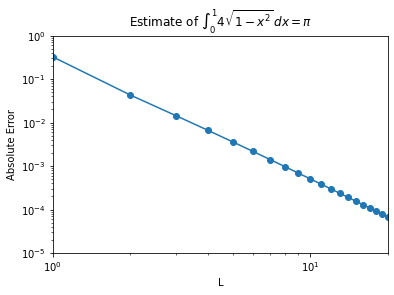

Slope of line from L = 8 to 11 is -2.848973886563485


In [16]:
L = np.arange(1,40)
errors = np.zeros(L.size)
f = lambda x: 4.0*np.sqrt(1-x**2)
integral = np.pi
for l in L:
    GLintegral = generalGL(f,0,1,l)
    errors[l-1] = np.fabs(GLintegral-integral)
    print("L =",l,"Estimate is",GLintegral,"Exact value is",integral)
plt.loglog(L,errors,'o-')
plt.xlabel("L")
plt.ylabel("Absolute Error")
plt.title("Estimate of $ \int_0^1 4\sqrt{1-x^2} \, dx = \pi$")
plt.axis([1,20,10**-5,10**0])
plt.show()
slope = (np.log(errors[-1]) - np.log(errors[0]))/(np.log(L[-1]) - np.log(L[0]) )
print("Slope of line from L = 8 to 11 is",slope)

There is a big difference between exponential convergence we saw in the integral of the sine function and the polynomial convergence in this problem. Even at a high rate of convergence (order 2.8), the error converges slowly in that we are still only accurate to 3 digits at $L=13.$

### Radau Quadrature

Sometimes we desire either:
* The first node is at the beginning of the interval, i.e., $x_1 = -1$ or
* The last node is at the end of the interval, i.e., $x_{L} = 1$.

This is known as **Gauss-Radu quadrature**. The remaining nodes and weights are chosen optimally; thus, Radu quadrature *exactly* integrates *all* polynomials of degree $2L-2$ or less. Specifying one of the nodes leaves only $2L-1$ degrees of freedom.

More info: http://mathworld.wolfram.com/RadauQuadrature.html


### Differential Equations

Consider solving the differential equation

$$\dot{x} = f(t,x), \quad x(t_0) = x_0,$$

to determine $x(t_f)$. This can be expressed as an integral:

$$x(t_f) = \int_{t_0}^{t_f} \frac{dx}{dt} dt + x_0 = \underbrace{\int_{t_0}^{t_f} f(t, x(t)) dt}_{\text{use quadrature rule}} + x_0$$

Thus, Runge-Kutta methods can be interpreted as a quadrature rule.